### Statistics - MASTER

In [89]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib.colors as colors
import seawater as sw
import math
import scipy.stats as stats
from matplotlib import axes


import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
77.24/60.41, 77.35/56.82

(1.2785962588975335, 1.361316437873988)

In [4]:
77.24/61.64, 77.35/57.46

(1.2530824140168721, 1.346153846153846)

In [2]:
datapath = '/scratch/usr/shkifmmp/master/data/'

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'

mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc', chunks={"y":100, "x":100})

In [8]:
def create_eddy_stat(model, year_start, year_end): #needs lots of improvement
    
#     if 'eddy_stat' in globals():
#         del globals()['eddy_stat']
    
    if 'tracks' in globals():
        del globals()['tracks']
        
#     elif region == 'acc':
    lon1= 77.5
    lon2= 69.5
    time_i = str(year_start)
    time_e = str(year_end)
    
    
    datapath_f = datapath + model + '/'
        
    with open(datapath_f + 'eddies_detect/acc/'
              + 'case9_' + time_i +'0101_' + str(time_e) + '1231_tracks_OW0.3'
              + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
        globals()['tracks'] = pickle.load(f)
    f.close()
    
    # for the regions
#     with open(datapath + 'eddies_detect/' + region + '/case7/'
#               + 'case7_19700101_19741231_tracks_OW0.3'
#               + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
#         globals()['tracks'] = pickle.load(f)
    #f.close()

    eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)

    #eddy_stat['case'] = 7 #2

    #calculating the life_time, scale, area
    for i in eddy_stat.index:
        eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])
    
#     for c in [7, 9]:
#     c = 9
#     del globals()['tracks']
#     if 'eddy_stat_aux' in locals():
#         del eddy_stat_aux


#     thr = str(3)


#     # This is how to open the tracks-file again (no need to do that if we just saved it)
#     with open(datapath + 'eddies_detect/' + region + '/case'+ str(c) +'/'
#               + 'case' + str(c) + '_19700101_19741231_tracks_OW0.' + thr
#               + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
#         globals()['tracks'] = pickle.load(f)
#     f.close()

#     eddy_stat_aux = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)

#     eddy_stat_aux['case'] = c

#     #calculating the life_time
#     for i in eddy_stat_aux.index:
#         eddy_stat_aux.loc[i, 'life_time'] = pd.to_datetime(eddy_stat_aux.time.iloc[i][-1]) - pd.to_datetime(eddy_stat_aux.time.iloc[i][0])
#         eddy_stat_aux.loc[i, 'area_mean'] = eddy_stat_aux.loc[i, 'area'].mean()
#         eddy_stat_aux.loc[i, 'area_max'] = eddy_stat_aux.loc[i, 'area'].max()
#         eddy_stat_aux.loc[i, 'scale_mean'] = eddy_stat_aux.loc[i, 'scale'].mean()
#         eddy_stat_aux.loc[i, 'scale_min'] = eddy_stat_aux.loc[i, 'scale'].min()
#         eddy_stat_aux.loc[i, 'scale_max'] = eddy_stat_aux.loc[i, 'scale'].max() 

#     #adding case 2 to dataframe
#     eddy_stat = eddy_stat.append(eddy_stat_aux)

#     eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True) 
#                       & (eddy_stat.life_time >= timedelta(days=30))]

    eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True)]
            
    for i in eddy_stat.index:
        lat = [eddy_stat.loc[i, 'lat'][0], eddy_stat.loc[i, 'lat'][-1]]
        lon = [eddy_stat.loc[i, 'lon'][0], eddy_stat.loc[i, 'lon'][-1]]
        eddy_stat.loc[i, 'distance'] = sw.extras.dist(lat,lon)[0]
        #eddy_stat.loc[i, 'speed'] = eddy_stat.loc[i, 'distance'] / eddy_stat.loc[i, 'life_time']
        eddy_stat.loc[i, 'speed'] = (eddy_stat.loc[i, 'distance'] *1e5)/ (eddy_stat.loc[i, 'life_time'].days * 24 * 3600) # cm/s
        eddy_stat.loc[i, 'angle'] = (sw.extras.dist(eddy_stat.loc[i, 'lat'], eddy_stat.loc[i, 'lon'])[1]).mean()
        eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
        eddy_stat.loc[i, 'amp_mean'] = eddy_stat.loc[i, 'amp'].mean()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
        eddy_stat.loc[i, 'scale_min'] = eddy_stat.loc[i, 'scale'].min()
        eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()
        
    # saving file
#     eddy_stat.to_pickle(path= datapath_f + 'eddies_detect/acc/eddy_stat_' + time_i + '_' + time_e + '.pkl')
    
#     eddy_stat.to_pickle(path= datapath_f + 'eddies_detect/acc/eddy_stat_all_' + time_i + '_' + time_e + '.pkl')

        
    return eddy_stat

In [12]:
# eddy_FO_01 = create_eddy_stat('ORION10X', 1958, 1977)

# eddy_FO_02 = create_eddy_stat('ORION10X', 1978, 1997)

# eddy_FO_03 = create_eddy_stat('ORION10X', 1998, 2017)

In [72]:
# time_i = str(1998)
# time_e = str(2017)
# datapath_f = datapath + 'ORION10' + '/'
# eddy_OR_03_lt30.to_pickle(path= datapath_f + 'eddies_detect/acc/eddy_stat_' + time_i + '_' + time_e + '.pkl')


In [69]:
# for i in eddy_OR_03_lt30.index:# DONE ONLY THE 3 PERIOD
#     eddy_OR_03_lt30.loc[i, 'amp_mean'] = eddy_OR_03_lt30.loc[i, 'amp'].mean()
#     # eddy_OR_03.loc[i, 'amp_mean'] = eddy_OR_03.loc[i, 'amp'].mean()

In [3]:
def open_eddy_stat(model, time_start, time_end):
    lon1= 77.5
    lon2= 69.5
    datapath_f = datapath + model
    time_i = str(time_start)
    time_e = str(time_end)
    with open(datapath_f + '/eddies_detect/acc/eddy_stat_' + time_i + '_' + time_e +  '.pkl', 'rb') as f:
        eddy_stat  = pickle.load(f)
        f.close()
    return eddy_stat

In [ ]:
# eddy_OR_01 = create_eddy_stat('ORION10', 1958, 1977)

# eddy_OR_02 = create_eddy_stat('ORION10', 1978, 1997)

# eddy_OR_03 = open_eddy_stat('ORION10', 1998, 2017)

In [5]:
eddy_OR_03 = open_eddy_stat('ORION10', 1998, 2017)

In [16]:
eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic'].amp_mean.describe()

count    6.043100e+04
mean     4.644794e-06
std      3.359701e-06
min      6.827113e-08
25%      2.224307e-06
50%      3.877613e-06
75%      6.184328e-06
max      3.202214e-05
Name: amp_mean, dtype: float64

In [18]:
eddy_OR_03.loc[eddy_OR_03.type == 'cyclonic'].amp_mean.describe()

count    6.600100e+04
mean     5.824432e-06
std      4.674095e-06
min      7.100405e-08
25%      2.491801e-06
50%      4.561680e-06
75%      7.817727e-06
max      4.496674e-05
Name: amp_mean, dtype: float64

In [21]:
eddy_FO_03.loc[eddy_FO_03.type == 'anticyclonic'].amp_mean.describe()

count    5.107400e+04
mean     5.375260e-06
std      4.095338e-06
min      1.380906e-07
25%      2.515751e-06
50%      4.393709e-06
75%      7.020178e-06
max      4.530222e-05
Name: amp_mean, dtype: float64

In [13]:
5.375260e-06 / 4.644794e-06 #anti

1.1572655321204772

In [15]:
6.447959e-06 / 4.644794e-06

1.388212049877777

In [6]:
eddy_FO_03 = open_eddy_stat('ORION10X', 1998, 2017)

In [ ]:
eddy_FO_03

In [17]:
eddy_stat = eddy_FO_03.loc[eddy_FO_03.type == 'anticyclonic']

### trying out plot things

In [7]:
mask_plot = mask_acc.mask_nest.where(mask_acc.mask_nest ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat > -65, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon > 75.5, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon < 431.58, other=0)

In [8]:
data = {'OR': {3: eddy_OR_03}, 'FO':{3: eddy_FO_03}}

## ANTICYCLONIC

In [ ]:
stats.kde.gaussian_kde?

In [33]:
# eddy_stat = data['OR'][3]
# for i in eddy_stat.index:
#     lon_try = eddy_stat.loc[i,'lon'][0]

In [90]:
eddy_stat = eddy_FO_03.loc[eddy_FO_03.type == 'anticyclonic']

k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z = stats.kde.gaussian_kde(xy)(xy)
idx = z.argsort()

x2, y2, z = x[idx], y[idx], z[idx]

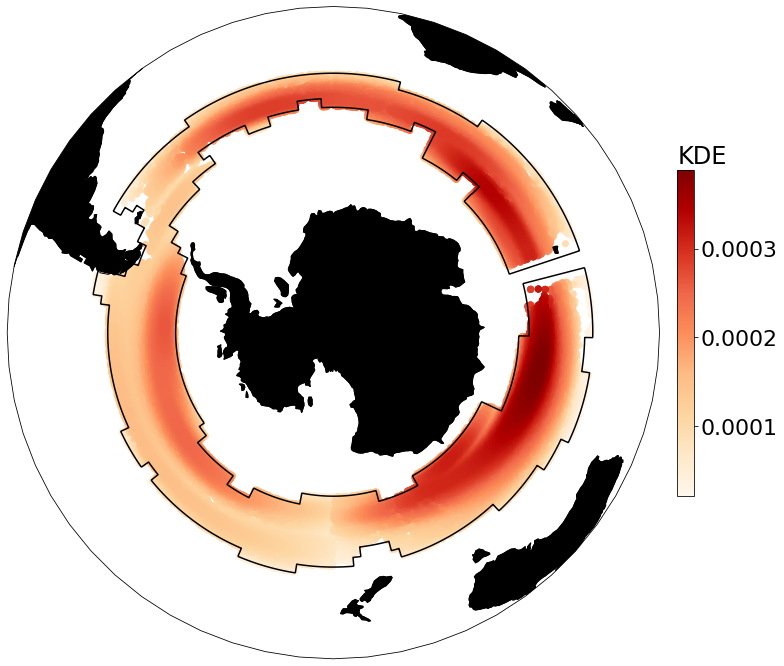

In [103]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7)

map1 = axs.scatter(x=x2, y=y2, c=z,transform= ccrs.PlateCarree(), cmap='OrRd',
                                    vmin=both_plot_min, vmax=both_plot_max)

# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'FO_eddies_anti_maps_OrRd_kde.png', format='png', facecolor="w", bbox_inches='tight')

In [72]:
f_anti_zmin

2.3460165256306963e-05

In [91]:
eddy_stat = eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic']

k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z_o = stats.kde.gaussian_kde(xy)(xy)
idx = z_o.argsort()

x2_o_a, y2_o_a, z_o_a = x[idx], y[idx], z_o[idx]

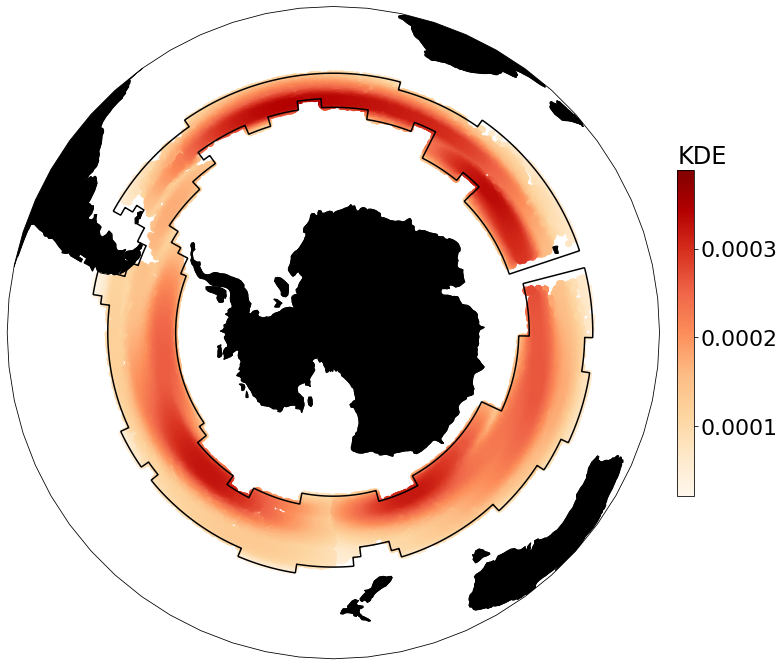

In [104]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7)

map1 = axs.scatter(x=x2_o_a, y=y2_o_a, c=z_o_a,transform= ccrs.PlateCarree(), cmap='OrRd',
                  vmin=both_plot_min, vmax=both_plot_max
                  )
# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'OR_eddies_anti_maps_OrRd_kde.png', format='png', facecolor="w", bbox_inches='tight')

In [92]:
o_anti_zmax, o_anti_zmin = z_o_a.max(), z_o_a.min()

In [93]:
f_anti_zmax, f_anti_zmin = z.max(), z.min()

In [94]:
o_anti_zmax, o_anti_zmin

(0.00034212141766505247, 2.119361052958737e-05)

In [95]:
f_anti_zmax, f_anti_zmin

(0.0003892907821314148, 2.3460165256306963e-05)

In [96]:
both_plot_max= f_anti_zmax

In [97]:
both_plot_min= o_anti_zmin

## CYCLONIC

In [105]:
# #FOCI
eddy_stat = eddy_FO_03.loc[eddy_FO_03.type == 'cyclonic']

k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z = stats.kde.gaussian_kde(xy)(xy)
idx = z.argsort()

x2, y2, z = x[idx], y[idx], z[idx]

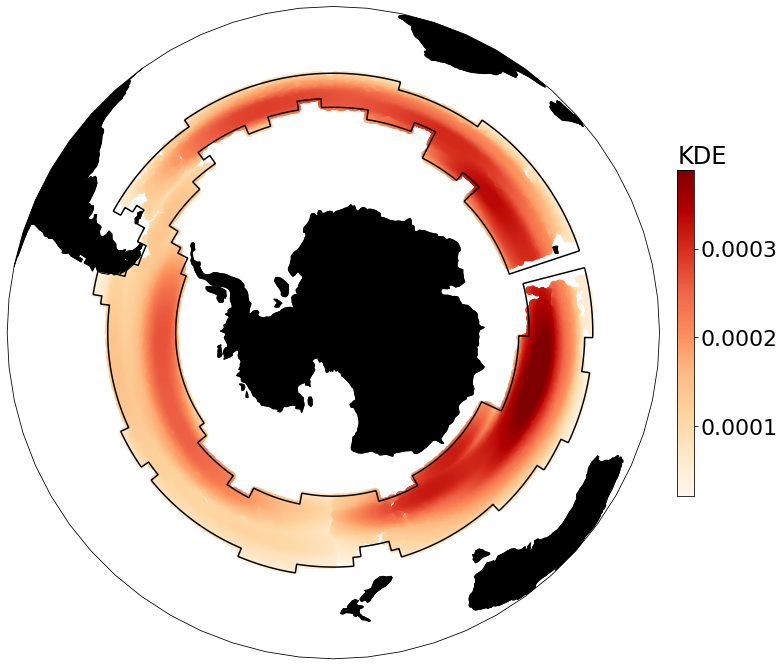

In [110]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7)

map1 = axs.scatter(x=x2, y=y2, c=z,transform= ccrs.PlateCarree(), cmap='OrRd', #'Blues'
                                    vmin=o_anti_zmin, vmax=f_anti_zmax)

# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'FO_eddies_cycl_maps_OrRd_kde.png', format='png', facecolor="w", bbox_inches='tight')

In [ ]:
#orion10

In [107]:
eddy_stat = eddy_OR_03.loc[eddy_OR_03.type == 'cyclonic']
k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z_o = stats.kde.gaussian_kde(xy)(xy)
idx = z_o.argsort()

x2_o_a, y2_o_a, z_o_a = x[idx], y[idx], z_o[idx]

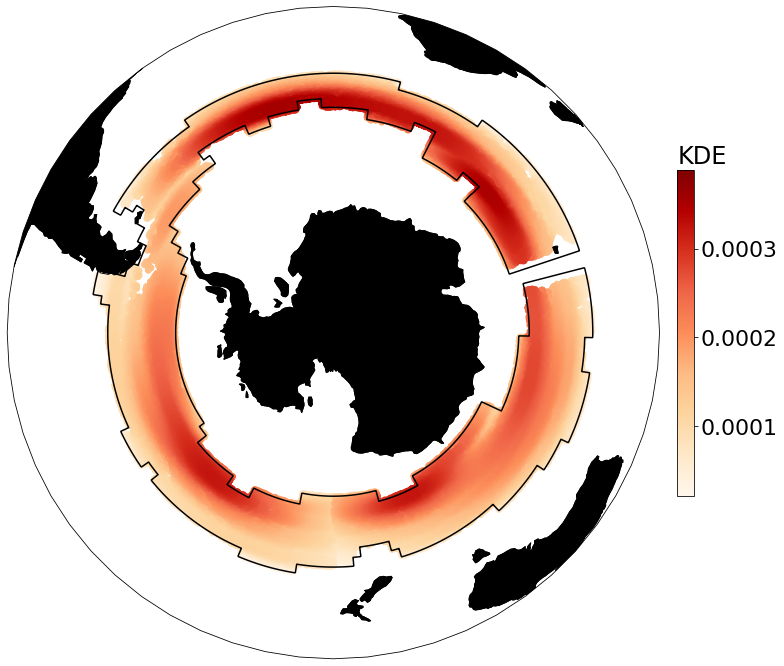

In [109]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=7)

map1 = axs.scatter(x=x2_o_a, y=y2_o_a, c=z_o_a,transform= ccrs.PlateCarree(), cmap='OrRd',
                  vmin=o_anti_zmin, vmax=f_anti_zmax)
# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('KDE', loc='left', fontsize=24)
c.ax.tick_params(labelsize=22)
axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'OR_eddies_cycl_maps_OrRd_kde.png', format='png', facecolor="w", bbox_inches='tight')

### whole thing

In [29]:
eddy_stat = eddy_OR_03
k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z_o = stats.kde.gaussian_kde(xy)(xy)
idx = z_o.argsort()

x2_o_a, y2_o_a, z_o_a = x[idx], y[idx], z_o[idx]

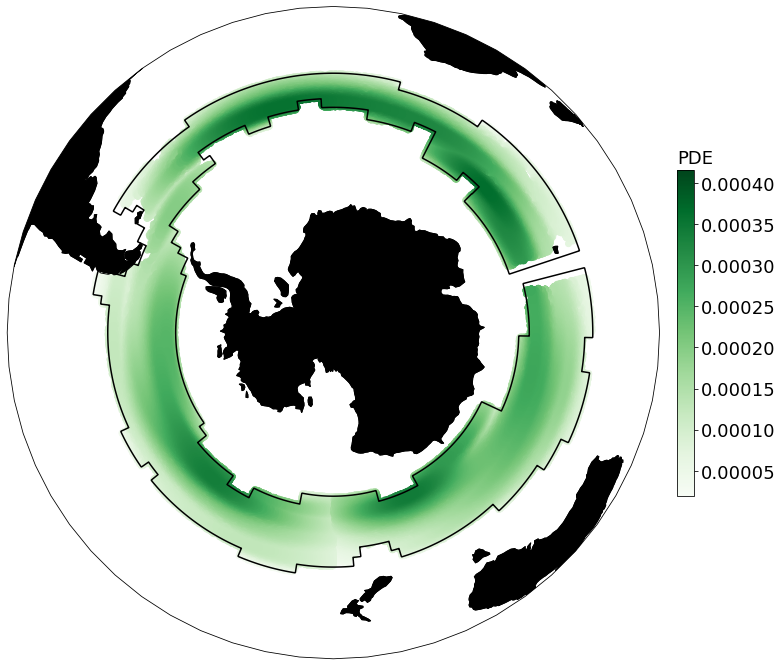

In [41]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=5, zorder=7)

map1 = axs.scatter(x=x2_o_a, y=y2_o_a, c=z_o_a,transform= ccrs.PlateCarree(), cmap='Greens',
                  vmin=o_anti_zmin, vmax=f_anti_zmax)
# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('PDE', loc='left', fontsize=18)
c.ax.tick_params(labelsize=18)
axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'OR_eddies_bothtypes_maps.png', format='png', facecolor="w", bbox_inches='tight')

In [30]:
# #FOCI
eddy_stat = eddy_FO_03

k = stats.kde.gaussian_kde([eddy_stat['lon'].str[0],eddy_stat['lat'].str[0]])

x=eddy_stat['lon'].str[0].values
y=eddy_stat['lat'].str[0].values

xy = np.vstack([eddy_stat['lon'].str[0], eddy_stat['lat'].str[0]])
z = stats.kde.gaussian_kde(xy)(xy)
idx = z.argsort()

x2, y2, z = x[idx], y[idx], z[idx]

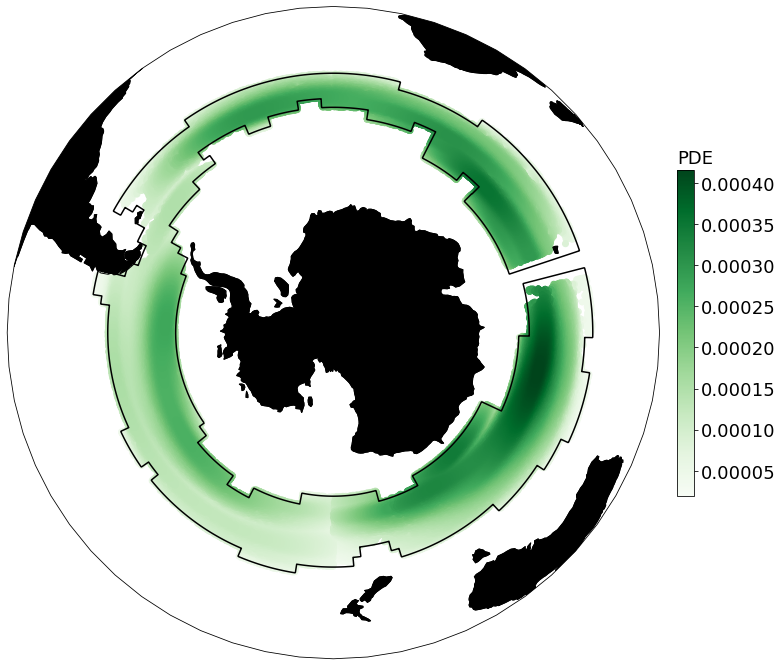

In [42]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=5, zorder=7)

map1 = axs.scatter(x=x2, y=y2, c=z,transform= ccrs.PlateCarree(), cmap='Greens',
                                    vmin=o_anti_zmin, vmax=f_anti_zmax)

# axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
#               cmap='inferno')


axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('PDE', loc='left', fontsize=18)
c.ax.tick_params(labelsize=18)
axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'
plt.savefig(savepath + 'FO_eddies_bothtypes_maps.png', format='png', facecolor="w", bbox_inches='tight')

## difference between models

In [24]:
# z.shape, z_o_a.shape # aborted

((51074,), (60431,))

In [25]:
4*61

244

In [ ]:
# fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

# axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
#             colors='black', levels=[1], linewidth=5, zorder=7)

# map1 = axs.scatter(x=(x2+x2_o_a)/2, y=(y2+y2_o_a)/2, c=z-z_o_a,transform= ccrs.PlateCarree(), cmap=cm.balance,
#                                   #  vmin=o_anti_zmin, vmax=f_anti_zmax
#                   )

# # axs.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', transform= ccrs.PlateCarree(),
# #               cmap='inferno')


# axs.set_global()
# axs.coastlines()
# axs.add_feature(cfeature.LAND, color='black')

# c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
# c.ax.set_title('PDE', loc='left', fontsize=18)
# c.ax.tick_params(labelsize=18)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=18)

## HISTOGRAMS

In [9]:
eddy_OR_01 = open_eddy_stat('ORION10', 1958, 1977)

eddy_OR_02 = open_eddy_stat('ORION10', 1978, 1997)

# eddy_OR_03 = open_eddy_stat('ORION10', 1998, 2017)

In [75]:
eddy_OR_03.loc[(eddy_OR_03.type == 'cyclonic')].life_time.mean()/ eddy_OR_03.loc[(eddy_OR_03.type == 'anticyclonic')].life_time.mean()# + eddy_OR_03.distance.mean())/2

1.0019435654222455

In [ ]:
eddy_OR_03.loc[(eddy_OR_03.type == 'cyclonic')].count() / eddy_OR_03.loc[(eddy_OR_03.type == 'anticyclonic')].count()

In [124]:
eddy_OR_03.speed.mean(), eddy_FO_03.speed.mean()

(2.2900217280759887, 2.366474953177211)

In [123]:
eddy_FO_03.speed.mean() / eddy_OR_03.speed.mean()

1.0333853710486216

In [83]:
(2*eddy_OR_03.loc[(eddy_OR_03.type == 'anticyclonic')].scale_mean.mean()) / (2*eddy_OR_03.loc[(eddy_OR_03.type == 'cyclonic')].scale_mean.mean())

1.0728796092690955

In [ ]:
52092

In [11]:
eddy_FO_01 = open_eddy_stat('ORION10X', 1958, 1977)

eddy_FO_02 = open_eddy_stat('ORION10X', 1978, 1997)

# eddy_FO_03 = open_eddy_stat('ORION10X', 1998, 2017)

In [ ]:
data = {'OR': {
         #1: eddy_OR_01, 
         #2: eddy_OR_02, 
         3:eddy_OR_03},
       'FO': {
#            1: eddy_FO_01, 
#            2: eddy_FO_02, 
           3: eddy_FO_03}}

In [67]:
eddy_OR_03.loc[:,'scale_mean'] *= 2

In [ ]:
eddy_OR_03

In [68]:
eddy_FO_03.loc[:,'scale_mean'] *= 2

In [217]:
eddy_OR_01.loc[(eddy_OR_01.type == 'cyclonic') & (eddy_OR_01.life_time.astype('timedelta64[D]') <= 365)].life_time.astype('timedelta64[D]')

1716      215.0
1725       40.0
1733       30.0
1737       35.0
1738       60.0
          ...  
434971     30.0
434992     30.0
435035     30.0
435095     30.0
435138     30.0
Name: life_time, Length: 65127, dtype: float64

In [41]:
data['FO'][3].loc[((data['FO'][3].scale_mean)>= 40) & (data['FO'][3].type == 'anticyclonic') ].describe()

,life_time,distance,angle,area_mean,area_max,scale_mean,scale_min,scale_max,speed,amp_mean
count,41118,41118.000000,41118.000000,41118.000000,41118.000000,41118.000000,41118.000000,41118.000000,41118.000000,4.111800e+04
mean,70 days 09:24:32.464614038,127.100362,-6.122738,3959.955650,5832.785198,66.823557,24.602490,41.071490,2.437256,6.049418e-06
std,52 days 23:01:07.571939701,88.114022,41.758626,2694.689011,3888.810414,21.205191,9.639748,13.029584,1.512552,4.216477e-06
min,30 days 00:00:00,0.051230,-173.312310,1259.902327,1365.939248,40.001759,9.175500,20.851666,0.000114,1.519911e-07
25%,35 days 00:00:00,65.804786,-31.877337,2031.856345,2965.540955,50.154223,17.477639,30.723948,1.316694,3.178268e-06
50%,55 days 00:00:00,107.461168,-7.189320,3089.800614,4609.761999,61.829811,22.300376,38.305780,2.144350,5.093907e-06
75%,85 days 00:00:00,166.050487,18.290467,4998.302024,7502.185016,78.698667,29.594620,48.867368,3.248650,7.749695e-06
max,1145 days 00:00:00,1071.833785,167.944212,22565.802071,26218.910253,169.374760,79.202819,91.355013,12.697943,4.530222e-05


In [42]:
(data['FO'][3].scale_mean).min()

19.592254857646445

In [ ]:
eddy_OR_0.loc[(eddy_OR_01.type == 'cyclonic') & (eddy_OR_01.life_time.astype('timedelta64[D]') <= 365)].life_time.astype('timedelta64[D]')

In [23]:
save_path

'/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/acc_statistics/'

In [78]:
def plot_hist(variable, interval, h_type, dist='pdf', ratio='cyc'):
    ''' 
        Return a line plot based on the histogram values 
        variable = 'life_time' / 'scale_mean' / 'distance';
        h_type = 'normal' / 'ratio';
        period = 1 / 2 / 3
    '''
    # RATIO ADAPTED ONLY FOR THE 3 PERIOD
    eddy_OR = data['OR'][3]
    eddy_FO = data['FO'][3]
#     eddy_OR = data['OR'][3].loc[(data['OR'][3].scale_mean)>= 40]
#     eddy_FO = data['FO'][3].loc[(data['FO'][3].scale_mean)>= 40]
    if h_type == 'normal':
        if variable == 'life_time':

    #         if type(interval) == float or type(interval) == int:
    #             bins_OR_c = math.ceil((eddy_OR.loc[eddy_OR.type == 'cyclonic']['life_time'].astype('timedelta64[W]').max() - 4) / interval)
    #             bins_OR_a = math.ceil((eddy_OR.loc[eddy_OR.type == 'anticyclonic']['life_time'].astype('timedelta64[W]').max() - 4) / interval)

    #             bins_FO_c = math.ceil((eddy_FO.loc[eddy_FO.type == 'cyclonic']['life_time'].astype('timedelta64[W]').max() - 4) / interval)
    #             bins_FO_a = math.ceil((eddy_FO.loc[eddy_FO.type == 'anticyclonic']['life_time'].astype('timedelta64[W]').max() - 4) / interval)

            if type(interval) == float or type(interval) == int:
                bins_OR_c = math.ceil((eddy_OR.loc[eddy_OR.type == 'cyclonic']['life_time'].astype('timedelta64[D]').max() 
                                       - eddy_OR.loc[eddy_OR.type == 'cyclonic']['life_time'].astype('timedelta64[D]').min()) / interval)
                bins_OR_a = math.ceil((eddy_OR.loc[eddy_OR.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').max() 
                                       - eddy_OR.loc[eddy_OR.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').min()) / interval)

                bins_FO_c = math.ceil((eddy_FO.loc[eddy_FO.type == 'cyclonic']['life_time'].astype('timedelta64[D]').max() 
                                       - eddy_FO.loc[eddy_FO.type == 'cyclonic']['life_time'].astype('timedelta64[D]').min()) / interval)
                bins_FO_a = math.ceil((eddy_FO.loc[eddy_FO.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').max() 
                                       - eddy_FO.loc[eddy_FO.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').min()) / interval)

            else:
                bins_OR_c = interval
                bins_OR_a = interval
                bins_FO_c = interval
                bins_FO_a = interval

            # ORION10
            y_c_10, bins_oc = np.histogram(eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable].astype('timedelta64[D]'), bins=bins_OR_c)
            y_a_10, bins_oa = np.histogram(eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable].astype('timedelta64[D]'), bins=bins_OR_a)
            mean_10_a = eddy_OR.loc[eddy_OR.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').mean()
            mean_10_c = eddy_OR.loc[eddy_OR.type == 'cyclonic']['life_time'].astype('timedelta64[D]').mean()
            # ORION10X
            y_c_10X, bins_fc = np.histogram(eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable].astype('timedelta64[D]'), bins=bins_FO_c)
            y_a_10X, bins_fa = np.histogram(eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable].astype('timedelta64[D]'), bins=bins_FO_a)
            mean_10X_a = eddy_FO.loc[eddy_FO.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').mean()
            mean_10X_c = eddy_FO.loc[eddy_FO.type == 'cyclonic']['life_time'].astype('timedelta64[D]').mean()

        else:

            if type(interval) == float or type(interval) == int:
                bins_OR_c = math.ceil((eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable].max() - eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable].min()) / interval)
                bins_OR_a = math.ceil((eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable].max() - eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable].min()) / interval)

                bins_FO_c = math.ceil((eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable].max() - eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable].min()) / interval)
                bins_FO_a = math.ceil((eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable].max() - eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable].min()) / interval)
            else:
                bins_OR_c = interval
                bins_OR_a = interval
                bins_FO_c = interval
                bins_FO_a = interval 

            # ORION10
            y_c_10, bins_oc = np.histogram(eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable], bins=bins_OR_c)
            y_a_10, bins_oa = np.histogram(eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable], bins=bins_OR_a)
            mean_10_a = eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable].mean()
            mean_10_c = eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable].mean()
            # ORION10X
            y_c_10X, bins_fc = np.histogram(eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable], bins=bins_FO_c)
            y_a_10X, bins_fa = np.histogram(eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable], bins=bins_FO_a)
            mean_10X_a = eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable].mean()
            mean_10X_c = eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable].mean()

    
    elif h_type == 'ratio':
        if variable == 'life_time':
            max_t=400
            if type(interval) == float or type(interval) == int:
                bins_OR_c = math.ceil((max_t - 30) / interval) #same bins for all

            else:
                bins_OR_c = interval

            # ORION10
            y_c_10, bins_oc = np.histogram(eddy_OR.loc[(eddy_OR.type == 'cyclonic') & (eddy_OR.life_time.astype('timedelta64[D]') <= max_t)].life_time.astype('timedelta64[D]'), bins=bins_OR_c)
            y_a_10, bins_oa = np.histogram(eddy_OR.loc[(eddy_OR.type == 'anticyclonic') & (eddy_OR.life_time.astype('timedelta64[D]') <= max_t)].life_time.astype('timedelta64[D]'), bins=bins_OR_c)
            mean_10_a = eddy_OR.loc[eddy_OR.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').mean()
            mean_10_c = eddy_OR.loc[eddy_OR.type == 'cyclonic']['life_time'].astype('timedelta64[D]').mean()
            # ORION10X
            y_c_10X, bins_fc = np.histogram(eddy_FO.loc[(eddy_FO.type == 'cyclonic') & (eddy_FO.life_time.astype('timedelta64[D]') <= max_t)].life_time.astype('timedelta64[D]'), bins=bins_OR_c)
            y_a_10X, bins_fa = np.histogram(eddy_FO.loc[(eddy_FO.type == 'anticyclonic') & (eddy_FO.life_time.astype('timedelta64[D]') <= max_t)].life_time.astype('timedelta64[D]'), bins=bins_OR_c)
            mean_10X_a = eddy_FO.loc[eddy_FO.type == 'anticyclonic']['life_time'].astype('timedelta64[D]').mean()
            mean_10X_c = eddy_FO.loc[eddy_FO.type == 'cyclonic']['life_time'].astype('timedelta64[D]').mean()

        else:
           
            if type(interval) == float or type(interval) == int:
                if variable == 'scale_mean':
                    var_min, var_max = 20.7, 169
                elif variable == 'speed':
                    var_min, var_max = 0.01, 12
                elif variable == 'distance':
                    var_min, var_max = 0.42, 1070
                elif variable == 'amp_mean':
                    var_min, var_max = 6.6*1e-8, 4.4*1e-5
                bins_OR_c = math.ceil((var_max - var_min) / interval)
                    
            else:
                bins_OR_c = interval

            # ORION10
            y_c_10, bins_oc = np.histogram(eddy_OR.loc[(eddy_OR.type == 'cyclonic') & (eddy_OR[variable] <= var_max)
                                                      & (eddy_OR[variable] >= var_min)][variable], bins=bins_OR_c)
            y_a_10, bins_oa = np.histogram(eddy_OR.loc[(eddy_OR.type == 'anticyclonic') & (eddy_OR[variable] <= var_max)
                                                      & (eddy_OR[variable] >= var_min)][variable], bins=bins_OR_c)
            mean_10_a = eddy_OR.loc[eddy_OR.type == 'anticyclonic'][variable].mean()
            mean_10_c = eddy_OR.loc[eddy_OR.type == 'cyclonic'][variable].mean()
            # ORION10X
            y_c_10X, bins_fc = np.histogram(eddy_FO.loc[(eddy_FO.type == 'cyclonic') & (eddy_FO[variable] <= var_max)
                                                      & (eddy_FO[variable] >= var_min)][variable], bins=bins_OR_c)
            y_a_10X, bins_fa = np.histogram(eddy_FO.loc[(eddy_FO.type == 'anticyclonic') & (eddy_FO[variable] <= var_max)
                                                      & (eddy_FO[variable] >= var_min)][variable], bins=bins_OR_c)
            mean_10X_a = eddy_FO.loc[eddy_FO.type == 'anticyclonic'][variable].mean()
            mean_10X_c = eddy_FO.loc[eddy_FO.type == 'cyclonic'][variable].mean()
    
    bincenters_oc= 0.5*(bins_oc[1:]+bins_oc[:-1])
    bincenters_oa= 0.5*(bins_oa[1:]+bins_oa[:-1])
    bincenters_fc= 0.5*(bins_fc[1:]+bins_fc[:-1])
    bincenters_fa= 0.5*(bins_fa[1:]+bins_fa[:-1])
    
#     if variable == 'scale_mean':
#         mean_10X_a *=2
#         mean_10X_c *=2 
#         mean_10_a *=2 
#         mean_10_c *=2
# #         bincenters *=2
#         bincenters_oc*=2
#         bincenters_oa*=2
#         bincenters_fc*=2
#         bincenters_fa*=2
        
    fig, axs = plt.subplots(figsize=(12,8))

    if h_type == 'normal':
        axs.plot(bincenters_oc, y_c_10, label= 'Cyclonic', color='mediumblue', linewidth=2)
        plt.plot(bincenters_fc, y_c_10X, label= 'Cyclonic', color= 'deepskyblue', linewidth=2)

        axs.plot(bincenters_oa, y_a_10, label= 'Anticyclonic', color='red', linewidth=2)
        plt.plot(bincenters_fa, y_a_10X, label= 'Anticyclonic', color = 'coral', linewidth=2) 
        
        axs.set_ylabel('Number of eddies', fontsize=24)
        
        if dist == 'log':
            plt.yscale('log')     
        
        axs.set_ylim(bottom=1e0)
        axs.axvline(x=mean_10_a, color='red', linestyle='--', linewidth=2)
        axs.axvline(x=mean_10_c, color='mediumblue', linestyle='--', linewidth=2)
        axs.axvline(x=mean_10X_a, color='coral', linestyle='--', linewidth=2)
        axs.axvline(x=mean_10X_c, color='deepskyblue', linestyle='--', linewidth=2)
        
        h, l = axs.get_legend_handles_labels()
        ph = [plt.plot([],marker="", ls="")[0]]*2
        handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
        labels = ["Uncoupled:"] + l[::2] + ["Coupled:"] + l[1::2]
        leg = plt.legend(handles, labels, ncol=2, fontsize=20)
        if variable == 'speed':
            leg = plt.legend(handles, labels, ncol=2, fontsize=20, loc='upper right')


        for vpack in leg._legend_handle_box.get_children():
            for hpack in vpack.get_children()[:1]:
                hpack.get_children()[0].set_width(0)
        
    elif h_type == 'ratio':
        
        if ratio == 'cyc':
            axs.plot((bincenters_oc + bincenters_oa)/2, (y_c_10/66001)/(y_a_10/60431), label='Uncoupled', color= 'midnightblue',linewidth=2)
            axs.plot((bincenters_fc + bincenters_fa)/2, (y_c_10X/54899)/(y_a_10X/51074), label= 'Coupled', color= 'r', linewidth=2)
            axs.axhline(y=1, color='k', linestyle='--')

            axs.set_ylabel('Ratio Cyclonic/Anticyclonic', fontsize=24)
            axs.set_ylim(bottom=0.25, top=1.75)
            
            
        elif ratio == 'unc':
            axs.plot((bincenters_oc + bincenters_fc)/2, (y_c_10/66001)/(y_c_10X/54899), label='Cyclonic', color= 'blue',linewidth=2)
            plt.plot((bincenters_oa + bincenters_fa)/2, (y_a_10/60431)/(y_a_10X/51074), label= 'Anticyclonic', color= 'red',linewidth=2)
            axs.axhline(y=1, color='k', linestyle='--', linewidth=2)

            axs.set_ylabel('Ratio Uncoupled/Coupled', fontsize=24)
            axs.set_ylim(bottom=0.25, top=1.75)
            
        if variable == 'speed' or variable == 'life_time' or variable == 'amp_mean':
            axs.set_xlim(left=0)
        
        axs.set_ylim(top=1.75)
        leg = axs.legend(fontsize=20)
        
    if variable == 'distance':
        axs.set_xlabel('Pathway length (km)', fontsize=24)
        axs.set_xlim(right=400, left=0)
        axs.set_ylim(bottom=10)
        save_title = 'distance'
        
        if h_type == 'ratio':
            axs.set_ylim(bottom=0.25, top=1.75)
        else:
            axs.set_ylim(bottom=10)
        
    elif variable == 'life_time':
        axs.set_xlabel('Lifetime (weeks)', fontsize=24)
        save_title = 'lifetime'
        axs.set_xlim(right=365, left=30) #left=30
        if h_type == 'normal':
            axs.set_ylim(bottom=1e1)
        
        labels= ['7', '14', '21', '28', '35', '42', '49']
        axs.set_xticks([49, 98, 147, 196, 245, 294, 343])
        axs.set_xticklabels(labels)
#         if h_type == 'ratio':
#             axs.set_ylim(top=2)

    elif variable == 'scale_mean':
        axs.set_xlabel('Mean diameter (km)', fontsize=24)
        save_title='meandiameter'
        axs.set_xlim(right=140)
        
        if h_type == 'ratio':
            axs.set_xlim(left=20)
   
        
    elif variable == 'speed':
        axs.set_xlabel('Propagation speed (cm$\,$s$^{-1}$)', fontsize=24)
        save_title='speed'
        axs.set_xlim(left=0, right=5)
        if dist == 'log':
            axs.set_ylim(bottom=1e1)
            
    elif variable == 'amp_mean':
        axs.set_xlim(left=-0.1*1e-5,right=2*1e-5)
        if h_type == 'normal':
            axs.set_ylim(bottom=10)            
        axs.xaxis.offsetText.set_fontsize(20)
        axs.set_xlabel('Vorticity amplitude (s$^{-1}$)', fontsize=24)
        save_title='amp'
        
    axs.tick_params(axis= 'x', labelsize= 24)
    axs.tick_params(axis= 'y', labelsize= 24)
    axs.grid()
    
    for line in leg.get_lines():
        line.set_linewidth(2)
        
#     if period == 1:
#         axs.set_title('1958 $-$ 1977', fontsize=20)
#     elif period == 2:
#         axs.set_title('1978 $-$ 1997', fontsize=20)
#     elif period == 3: 
#         axs.set_title('1998 $-$ 2017',fontsize=20)
        
#     if variable == 'scale_mean':
#         axs.set_title('a)', loc='left', fontsize=22)
#     elif variable == 'life_time':
#         axs.set_title('b)', loc='left', fontsize=22)
#     elif variable == 'distance':
#         axs.set_title('c)', loc='left', fontsize=22)
#     elif variable == 'speed':
#         axs.set_title('d)', loc='left', fontsize=22)

#     if ratio == 'cyc': #for other periods
#         plt.savefig(save_path + '220214/'+ 'statistics_acc_'+ save_title + '_0' + str(period) + '_' + h_type + '_' + dist + '_' + str(interval) + 'interval.png', format='png', facecolor="w",  bbox_inches='tight')
    
    if ratio == 'cyc':
        plt.savefig(save_path + '220225/'+ 'statistics_acc_'+ save_title + '_this_' + h_type + '_' + dist + '_' + str(interval) + 'interval.png', format='png', facecolor="w",  bbox_inches='tight')
    
    elif ratio == 'unc':
        plt.savefig(save_path + '220225/statistics_acc_'+ save_title + '_this_' + h_type + '_' + dist + '_' + str(interval) + 'interval_unc.png', format='png', facecolor="w",  bbox_inches='tight')


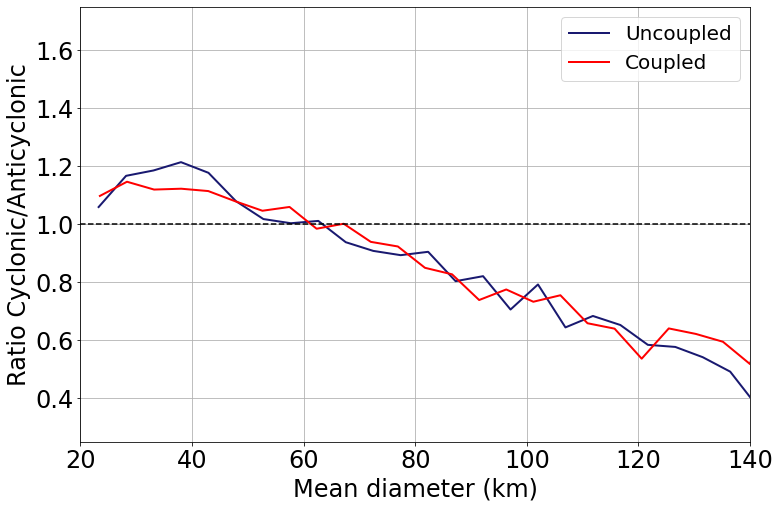

In [88]:
plot_hist('scale_mean',5, 'ratio')

In [79]:
y_c_10, bins_g = np.histogram(eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic']['amp_mean'], range=(6.6*1e-8, 4.4*1e-5), bins='auto')

In [281]:
# eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic']['life_time'].astype('timedelta64[W]').max()

526.0

In [81]:
bincenters= 0.5*(bins_g[1:]+bins_g[:-1])

In [83]:
bincenters[1] - bincenters[0]

2.0153211009174313e-07

### temporal variability

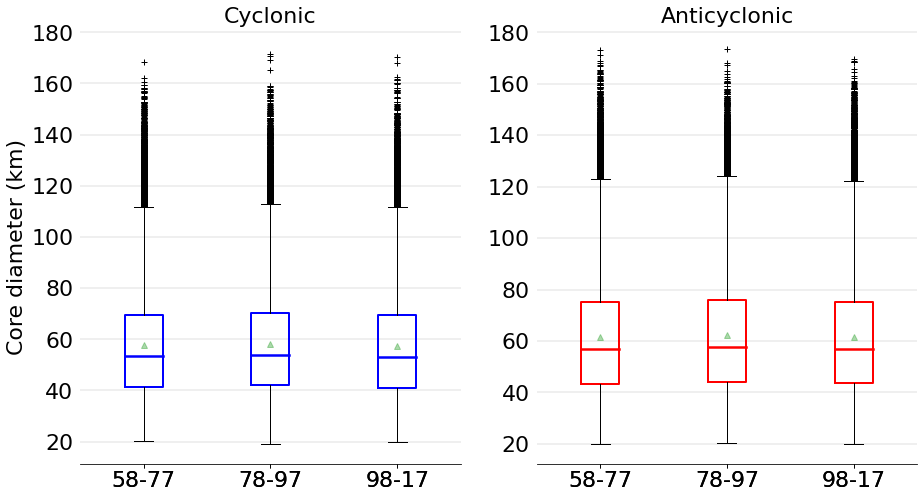

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,8), sharex=True)
# meanlineprops = dict(linestyle='-', linewidth=2.5, color='r', alpha=0.4)
medianprops = dict(linestyle='-', linewidth=2.5, color='r')
medianprops_c = dict(linestyle='-', linewidth=2.5, color='b')


labels=['58-77', '78-97', '98-17']
data_bp1 = ([(eddy_OR_01.loc[eddy_OR_01.type == 'cyclonic']['scale_mean']*2), (eddy_OR_02.loc[eddy_OR_02.type == 'cyclonic']['scale_mean']*2),
       (eddy_OR_03.loc[eddy_OR_03.type == 'cyclonic']['scale_mean']*2)])
axs[0].boxplot(data_bp1, showfliers=True, labels=labels, boxprops={'color':'b', 'linewidth':2}, flierprops={'marker':'+'},
                            meanprops = meanlineprops, showmeans=True, medianprops=medianprops_c)
axs[0].set_title('Cyclonic', fontsize= 22)

data_bp2 = [(eddy_OR_01.loc[eddy_OR_01.type == 'anticyclonic']['scale_mean']*2), (eddy_OR_02.loc[eddy_OR_02.type == 'anticyclonic']['scale_mean']*2),
       (eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic']['scale_mean']*2)]
axs[1].boxplot(data_bp2, showfliers=True, labels=labels, boxprops={'color':'r', 'linewidth':2},flierprops={'marker':'+'},# meanline=True,
              meanprops = meanlineprops, showmeans=True, medianprops=medianprops)
axs[1].set_title('Anticyclonic', fontsize= 22)

axs[0].set_ylabel('Core diameter (km)', fontsize=22)

ylim1 = axs[0].get_ylim()[1]
ylim2 = axs[1].get_ylim()[1]
# axs[1].yaxis.set_ticks_labels('none')


for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.grid(color='grey', axis='y', alpha=0.6, linewidth=0.4)
    ax.tick_params(axis= 'x', labelsize= 22)
    ax.tick_params(axis= 'y', labelsize= 22)
    ax.set_ylim(top=max(ylim1,ylim2))
    
axs[0].get_shared_x_axes().join(axs[0], axs[1])

plt.savefig(save_path + '220214/statistics_acc_example_boxplot_diameter.png', format='png', facecolor="w",  bbox_inches='tight')


In [47]:
eddy_FO_03.speed.mean()/eddy_OR_03.speed.mean()

1.0333853710486216

### statistiiiics

In [2]:
stats.ks_2samp?

Signature: stats.ks_2samp(data1, data2, alternative='two-sided', mode='auto')
Docstring:
Compute the Kolmogorov-Smirnov statistic on 2 samples.

This is a two-sided test for the null hypothesis that 2 independent samples
are drawn from the same continuous distribution.  The alternative hypothesis
can be either 'two-sided' (default), 'less' or 'greater'.

Parameters
----------
data1, data2 : array_like, 1-Dimensional
    Two arrays of sample observations assumed to be drawn from a continuous
    distribution, sample sizes can be different.
alternative : {'two-sided', 'less', 'greater'}, optional
    Defines the alternative hypothesis.
    The following options are available (default is 'two-sided'):

      * 'two-sided'
      * 'less': one-sided, see explanation in Notes
      * 'greater': one-sided, see explanation in Notes
mode : {'auto', 'exact', 'asymp'}, optional
    Defines the method used for calculating the p-value.
    The following options are available (default is 'auto'):

 

In [26]:
eddy_OR_03.loc[eddy_OR_03.type == 'cyclonic'].amp_mean.values

array([7.16526407e-06, 5.63081181e-06, 9.20295463e-06, ...,
       4.57944881e-06, 5.40072121e-06, 6.59632895e-06])

In [34]:
# stats.kstest(rvs=eddy_OR_03.loc[eddy_OR_03.type == 'cyclonic'].life_time.values, cdf= eddy_OR_03.loc[eddy_OR_03.type == 'anticyclonic'].life_time.values)

KstestResult(statistic=0.003369161422319855, pvalue=0.8651452197272008)

In [59]:
stats.ks_2samp(eddy_FO_03.scale_mean.values, eddy_OR_03.scale_mean.values)

KstestResult(statistic=0.014758773266514313, pvalue=2.4482723530732672e-11)

In [ ]:
# y,binEdges=np.histogram(data,bins=100)
# bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
# hist_y, hist_bins,  = eddy_stat_10.loc[eddy_stat_10.type == 'cyclonic'][].hist(column = 'distance', bins=12, histtype='step')

In [148]:
eddy_stat_10.loc[eddy_stat_10.type == 'anticyclonic'].distance.max()

839.7336218827263

In [84]:
range

range

In [59]:
eddy_stat_10.loc[eddy_stat_10.type == 'cyclonic'].distance.max()

1219.80332449613

In [140]:
1218/121

10.066115702479339

In [26]:
for i in eddy_stat_10.index:
        eddy_stat_10.loc[i, 'distance'] = (sw.extras.dist(eddy_stat_10.loc[i, 'lat'], eddy_stat_10.loc[i, 'lon'])[0]).sum()
        eddy_stat_10.loc[i, 'angle'] = (sw.extras.dist(eddy_stat_10.loc[i, 'lat'], eddy_stat_10.loc[i, 'lon'])[1]).mean()

In [17]:
lat =[40, 30, 35]
lon = [30,32,31]

In [24]:
(sw.extras.dist(eddy_stat_10.loc[1666, 'lat'], eddy_stat_10.loc[1666, 'lon'])[0]).sum()

60.74373820168496

In [19]:
eddy_stat_10.loc[1666, 'lat']

array([-63.94861499, -63.92290851, -63.91184892, -63.92651366,
       -63.94475928, -63.96160604, -63.9819319 , -63.99443373])

In [19]:
%time?

Docstring:
Time execution of a Python statement or expression.

The CPU and wall clock times are printed, and the value of the
expression (if any) is returned.  Note that under Win32, system time
is always reported as 0, since it can not be measured.

This function can be used both as a line and cell magic:

- In line mode you can time a single-line statement (though multiple
  ones can be chained with using semicolons).

- In cell mode, you can time the cell body (a directly
  following statement raises an error).

This function provides very basic timing functionality.  Use the timeit
magic for more control over the measurement.

.. versionchanged:: 7.3
    User variables are no longer expanded,
    the magic line is always left unmodified.

Examples
--------
::

  In [1]: %time 2**128
  CPU times: user 0.00 s, sys: 0.00 s, total: 0.00 s
  Wall time: 0.00
  Out[1]: 340282366920938463463374607431768211456L

  In [2]: n = 1000000

  In [3]: %time sum(range(n))
  CPU times: user 1.20 s,